In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## How inference works:

Step 1. A vidoe is cut into frames and every 15th (sample rate parameter) frame is taken. Then features are extracted out of them using GoogleNet. Here we have a matrix with dimentions (n_frames/15, 1024). 

Step 2. Shot boundary detection algorithm (KTS) then divides into shots in the following way: multiply feature matrix by transposed feature matrix and perform dynamic programming based algorithm twice on matrix (with dimentions (n_frames/15, n_frames/15). 

Step 3. Prediction summary with PGL-SUM (or other models). Model result - binary vector of length n_frames/15, 1 - good frame, 0 - otherwise. After it average scores for every shot are computed and a summary is filled with the best shots but no longer than 15% of an initial video.

## Problem:

Videos with the large number of frames take a long time at step 2 (shot boundary detection).

## Solution:

I cut feature matrix into parts by 300 frames (approximately 2,5 min of initial video) and process every part with shot boundary detection algorithm separately then concatenate results. I compared for some videos and found that boundaries are almost completely the same. Sometimes boundaries are a bit shifted on cut's edges but it's ok.

## Result:

Longest video with 200k frames (93 min) initially was processed with Shot boundary detection algorithm for 10303 sec, now it's 17 sec! So longer videos are more acceptable.

In [2]:
long_videos_info = pd.read_csv('long_videos_processing_info.csv')

In [3]:
# frames per second, only every 15 frame is selected
long_videos_info['feature_extraction_fpc_with_cut'] = long_videos_info['n_frames'] / 15 / long_videos_info['feature_extraction_time_with_cut'] 
long_videos_info['feature_extraction_fpc'] = long_videos_info['n_frames'] / 15 / long_videos_info['feature_extraction_time'] 

long_videos_info.sort_values("n_frames", inplace=True)

long_videos_info

,video_name,video_duration_min,n_frames,feature_extraction_time_with_cut,feature_extraction_time,shot_boundaries_cut_time,shot_boundaries_time,all_preprocessing_with_cut,all_preprocessing,writing_summary_video_with_cut,writing_summary_video,feature_extraction_fpc_with_cut,feature_extraction_fpc
0,documentary_global_warming_16_min[uynhvHZUOOo]...,16,24577,68.460950,66.629404,2.713922,16.774421,130.828073,142.200668,44.881229,43.835340,23.932865,24.590745
1,documentary_speech_drawing_22_min[EvknN89JoWo]...,22,32474,90.493963,87.414481,3.266361,34.996869,174.416812,197.548928,59.564553,58.717488,23.923511,24.766301
2,documentary_energy_23_min[pafA-RU3q7U].mp4,23,33745,80.189347,81.271607,2.963841,32.226068,175.061479,208.444078,53.283302,53.530347,28.054433,27.680844
3,educational_economics_26_min[QSkKG5bthSA].mp4,26,46620,129.917731,128.598114,4.399150,79.142484,486.598412,896.314450,80.552204,75.045374,23.922832,24.168317
4,documentary_web_40_min[cL3pEe47qyk].mp4,40,60624,145.494985,151.332021,4.848344,171.168229,285.111929,446.785676,102.192026,101.868411,27.778277,26.706840
5,documentary_travel_42_min[TcqAu8VyjZA].mp4,42,63627,173.276285,173.246825,5.780578,217.648349,224.048139,434.837051,107.265568,107.167137,24.479980,24.484143
6,documentary_rich_people_42_min[NXaVLXSZdEw].mp4,42,63641,173.480861,152.713648,5.996494,210.727978,364.714586,789.117405,92.597267,81.347300,24.456492,27.782280
7,documentary_companies_42_min[Dy8ogOaKk4Y].mp4,42,63648,153.075265,160.207904,4.754560,172.825696,157.929140,333.182681,91.818536,94.862713,27.719697,26.485585
8,documentary_crime_51_min[gWe1TJQ-6HI].mp4,51,73321,197.608428,199.751655,6.936482,338.765332,311.924190,645.801045,124.299673,124.620214,24.736124,24.470719
9,documentary_supply_chain_55_min[1KtTAb9Tl6E].mp4,55,78712,191.545892,202.278838,6.264263,375.068686,405.011638,869.812704,134.674305,124.184281,27.395350,25.941748


In [4]:
result = long_videos_info

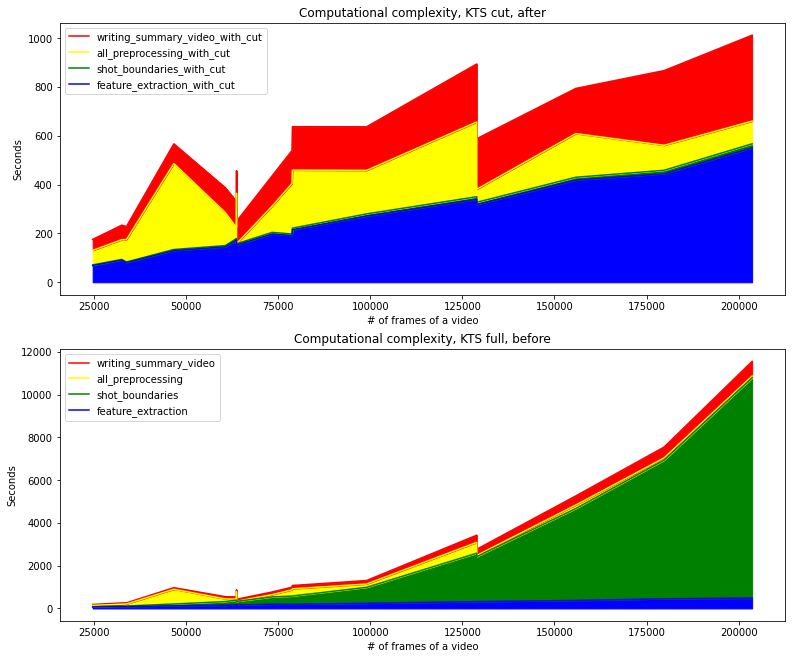

In [5]:
plt.figure(figsize=(13,11))

result.sort_values("n_frames", inplace=True)

plt.subplot(2,1,1)

plt.title('Computational complexity, KTS cut, after')
plt.xlabel("# of frames of a video")
plt.ylabel("Seconds")

plt.plot(result['n_frames'], result['all_preprocessing_with_cut'] + result['writing_summary_video_with_cut'], 
         label="writing_summary_video_with_cut", color='red')

plt.plot(result['n_frames'], result['all_preprocessing_with_cut'], 
         label="all_preprocessing_with_cut", color='yellow')

plt.plot(result['n_frames'], result['feature_extraction_time_with_cut'] + result['shot_boundaries_cut_time'], 
         label="shot_boundaries_with_cut", color='green')
plt.plot(result['n_frames'], result['feature_extraction_time_with_cut'] , 
         label="feature_extraction_with_cut", color='blue')

plt.fill_between(result['n_frames'], result['feature_extraction_time_with_cut'], color='blue')
plt.fill_between(result['n_frames'], result['feature_extraction_time_with_cut'], 
                 result['feature_extraction_time_with_cut'] + result['shot_boundaries_cut_time'], color='green')
plt.fill_between(result['n_frames'], result['feature_extraction_time_with_cut'] + result['shot_boundaries_cut_time'], 
                 result['all_preprocessing_with_cut'], color='yellow')
plt.fill_between(result['n_frames'], result['all_preprocessing_with_cut'], 
                 result['all_preprocessing_with_cut'] + result['writing_summary_video_with_cut'], color='red')

plt.legend()


plt.subplot(2,1,2)

plt.title('Computational complexity, KTS full, before')
plt.xlabel("# of frames of a video")
plt.ylabel("Seconds")


plt.plot(result['n_frames'], result['all_preprocessing'] + result['writing_summary_video'], 
         label="writing_summary_video", color='red')

plt.plot(result['n_frames'], result['all_preprocessing'], 
         label="all_preprocessing", color='yellow')

plt.plot(result['n_frames'], result['feature_extraction_time'] + result['shot_boundaries_time'], 
         label="shot_boundaries", color='green')
plt.plot(result['n_frames'], result['feature_extraction_time'] , 
         label="feature_extraction", color='blue')

plt.fill_between(result['n_frames'], result['feature_extraction_time'], color='blue')
plt.fill_between(result['n_frames'], result['feature_extraction_time'], 
                 result['feature_extraction_time'] + result['shot_boundaries_time'], color='green')
plt.fill_between(result['n_frames'], result['feature_extraction_time'] + result['shot_boundaries_time'], 
                 result['all_preprocessing'], color='yellow')
plt.fill_between(result['n_frames'], result['all_preprocessing'], 
                 result['all_preprocessing'] + result['writing_summary_video'], color='red')

plt.legend()


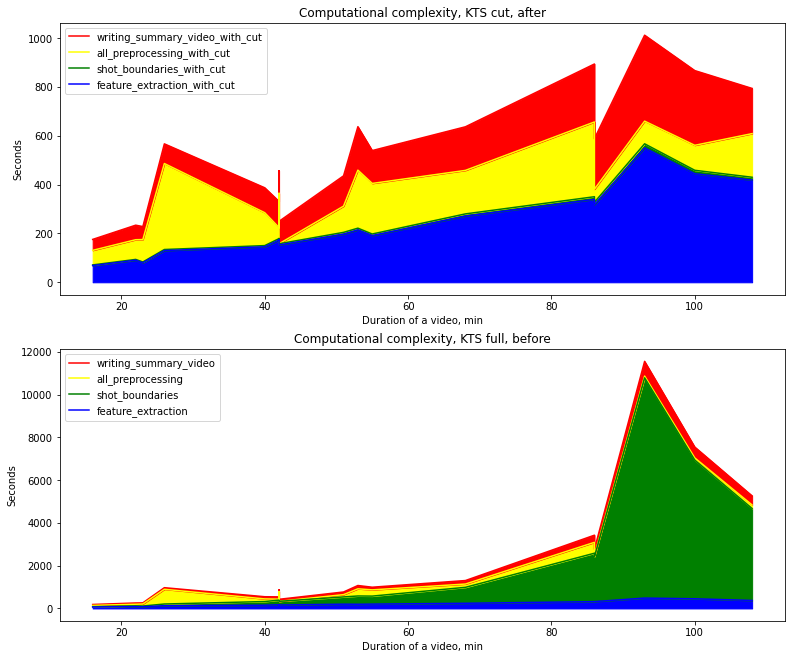

In [6]:
plt.figure(figsize=(13,11))

result.sort_values("video_duration_min", inplace=True)



plt.subplot(2,1,1)

plt.title('Computational complexity, KTS cut, after')
plt.xlabel("Duration of a video, min")
plt.ylabel("Seconds")


plt.plot(result['video_duration_min'], result['all_preprocessing_with_cut'] + result['writing_summary_video_with_cut'], 
         label="writing_summary_video_with_cut", color='red')

plt.plot(result['video_duration_min'], result['all_preprocessing_with_cut'], 
         label="all_preprocessing_with_cut", color='yellow')

plt.plot(result['video_duration_min'], result['feature_extraction_time_with_cut'] + result['shot_boundaries_cut_time'], 
         label="shot_boundaries_with_cut", color='green')
plt.plot(result['video_duration_min'], result['feature_extraction_time_with_cut'] , 
         label="feature_extraction_with_cut", color='blue')

plt.fill_between(result['video_duration_min'], result['feature_extraction_time_with_cut'], color='blue')
plt.fill_between(result['video_duration_min'], result['feature_extraction_time_with_cut'], 
                 result['feature_extraction_time_with_cut'] + result['shot_boundaries_cut_time'], color='green')
plt.fill_between(result['video_duration_min'], result['feature_extraction_time_with_cut'] + result['shot_boundaries_cut_time'], 
                 result['all_preprocessing_with_cut'], color='yellow')
plt.fill_between(result['video_duration_min'], result['all_preprocessing_with_cut'], 
                 result['all_preprocessing_with_cut'] + result['writing_summary_video_with_cut'], color='red')

plt.legend()


plt.subplot(2,1,2)

plt.title('Computational complexity, KTS full, before')
plt.xlabel("Duration of a video, min")
plt.ylabel("Seconds")


plt.plot(result['video_duration_min'], result['all_preprocessing'] + result['writing_summary_video'], 
         label="writing_summary_video", color='red')

plt.plot(result['video_duration_min'], result['all_preprocessing'], 
         label="all_preprocessing", color='yellow')

plt.plot(result['video_duration_min'], result['feature_extraction_time'] + result['shot_boundaries_time'], 
         label="shot_boundaries", color='green')
plt.plot(result['video_duration_min'], result['feature_extraction_time'] , 
         label="feature_extraction", color='blue')

plt.fill_between(result['video_duration_min'], result['feature_extraction_time'], color='blue')
plt.fill_between(result['video_duration_min'], result['feature_extraction_time'], 
                 result['feature_extraction_time'] + result['shot_boundaries_time'], color='green')
plt.fill_between(result['video_duration_min'], result['feature_extraction_time'] + result['shot_boundaries_time'], 
                 result['all_preprocessing'], color='yellow')
plt.fill_between(result['video_duration_min'], result['all_preprocessing'], 
                 result['all_preprocessing'] + result['writing_summary_video'], color='red')

plt.legend()


With cut of feature matrix into parts and processing them separately shot boundary time is very low